In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
import numpy as np
from scipy.stats import weibull_min
import numpy as np


## Part 1: Study of Dataset

This is the part, where we learn more about the dataset. It may not contribute to the grade as much as the next part, but it still matters.

One of the main assumptions is that each cell is equivalent to 30 mins. Many calculations will hinge on this assumption

In [3]:
data = pd.read_csv("la_rochelle.csv")
data.loc[data.duplicated(keep=False), :]
df = pd.DataFrame(data)
print(df.iloc[0])

air_temp                                    9
albedo                                   0.13
azimuth                                    -4
clearsky_dhi                                0
clearsky_dni                                0
clearsky_ghi                                0
clearsky_gti                                0
cloud_opacity                             0.0
dewpoint_temp                             6.6
dhi                                         0
dni                                         0
ghi                                         0
gti                                         0
precipitable_water                       11.8
precipitation_rate                        0.0
relative_humidity                        84.5
surface_pressure                       1013.4
snow_depth                                0.0
snow_water_equivalent                     0.0
snow_soiling_rooftop                        0
snow_soiling_ground                         0
wind_direction_100m               

At first, I thought that azimuth is one of the wind variables. But I realized that it has little importance for what comes next, so I removed it.

In [4]:
df = pd.DataFrame(data, columns = ["wind_direction_100m", "wind_direction_10m", "wind_speed_100m", "wind_speed_10m", "period_end", "period"])
print(df.iloc[0])

wind_direction_100m                     221
wind_direction_10m                      217
wind_speed_100m                         8.4
wind_speed_10m                          4.7
period_end             2014-01-01T00:30:00Z
period                                PT30M
Name: 0, dtype: object


This part of the code takes the data for only one year from the dataframe. I'll eventually do the same thing for each year of the dataframe.

In [5]:
# define the column for the date and convert its data to the date/time period
df["period_end"]=pd.to_datetime(df["period_end"], format="%Y-%m-%dT%H:%M:%SZ")

# Original date
start_date = df["period_end"].iloc[0]

# Add one year to the date
end_date = start_date + relativedelta(years=1)

# contain the dataset to only 1 year
df1 = df[df["period_end"] <= end_date]

df1["wind_speed_10m"].astype(float)
df1["wind_speed_100m"].astype(float)
df1["wind_direction_10m"].astype(float)
df1["wind_direction_100m"].astype(float)


# sample of the dataset with much fewer data points, all selected randomly
df2 = df1.sample(n=400, random_state=42)

# print the dataset to make sure it's exactly 1 year
print(df1)

       wind_direction_100m  wind_direction_10m  wind_speed_100m  \
0                      221                 217              8.4   
1                      220                 216              8.4   
2                      219                 215              8.5   
3                      219                 214              8.6   
4                      217                 212              8.8   
...                    ...                 ...              ...   
17516                   96                  94              5.8   
17517                   98                  96              5.5   
17518                   99                  96              5.1   
17519                  100                  95              4.5   
17520                  101                  94              4.1   

       wind_speed_10m          period_end period  
0                 4.7 2014-01-01 00:30:00  PT30M  
1                 4.8 2014-01-01 01:00:00  PT30M  
2                 4.9 2014-01-01 01:30:00 

I plotted four graphs, one for each wind-related variable, over the course of one year. Since 17500 points for each graph is too much, I decided to randomly select only 400 points beforehand.

In [6]:
variable_list = ["wind_direction_100m", "wind_direction_10m", "wind_speed_100m", "wind_speed_10m"]
fig, axs = plt.subplots(4, 1, figsize=(12, 18))
ax_index = 0
for variable in variable_list:
    ax_current = axs[ax_index]
    sns.lineplot(ax = ax_current, x=df2["period_end"],y=df2[variable], label=variable)
    ax_current.set_ylabel('Wind data')
    ax_current.set_xlabel('Date')
    ax_index+=1
plt.savefig("wind_variables_1year.webp")
plt.close()


# # this takes too much time, even though it's only 17500 data points. For this reason, I am using the dataset with 400 random points
# plt.figure(figsize=(12, 6))
# sns.lineplot(x=df2["period_end"],y=df2["wind_direction_100m"], label="wind_direction_100m")
# sns.lineplot(x=df2["period_end"],y=df2["wind_speed_100m"], label="wind_speed_100m")
# plt.ylabel('Wind data')
# plt.xlabel('Date')
# plt.yscale("log")
# plt.legend()
# plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set maximum number of major ticks
# plt.savefig("wind_variables_1year.webp")
# plt.close()

This code here checks how many hours

In [7]:
# epsilon is a tolerance value, which accounts for data points very close to 0, but not equal to 0
# in this case it means wind speed so small, that it's negligible
epsilon = 4

df3 = df1[df1["wind_speed_100m"]<=epsilon]
print(df3)

# assuming that each period is around 30 mins=0.5 hrs, the amount of time, for which wind speed was negligible, is 
print(0.5*df3.shape[0], " hours without meaningful wind")

       wind_direction_100m  wind_direction_10m  wind_speed_100m  \
341                    188                 164              3.9   
342                    182                 156              3.7   
343                    174                 148              3.8   
408                    281                 281              4.0   
409                    281                 281              3.7   
...                    ...                 ...              ...   
17496                   78                  78              3.9   
17497                   72                  71              3.6   
17498                   66                  65              3.6   
17499                   62                  62              3.8   
17500                   61                  61              4.0   

       wind_speed_10m          period_end period  
341               2.1 2014-01-08 03:00:00  PT30M  
342               2.1 2014-01-08 03:30:00  PT30M  
343               2.2 2014-01-08 04:00:00 

Plots over the course of 1 year the monthly average features of the wind. Wind speed for 100 m/10 m height, as well as wind direction for 100 m/10 m height.
Also, I printed the start/end values of each month to make sure, that my code correctly understands how to plot that graph.

In [31]:
# this will be a loop for finding monthly averages of wind features
# starting date of the month. In this case it's the starting date of the year
startmonth = df1["period_end"].iloc[0]
# ending date of the month. Will be defined at the beginning of each iteration of the loop
endmonth = startmonth+relativedelta(months=1)-timedelta(days=1)
# end of the year, used as stopping condition for the while loop
endyear = df1["period_end"].iloc[-1]

# print endyear and startmonth just to make sure
print(endyear)
print(startmonth)

# can't use start month and end month as indices, can I?
# so I ought to use boolean indexing
# and yes, avg_wind_direction_100m is different from avg_wind_direction_10m. Difference is negligible, but exists
avg_wind_direction_100m_list=[]
avg_wind_direction_10m_list=[]
avg_wind_speed_100m_list=[]
avg_wind_speed_10m_list=[]

# list of months
monthlist = calendar.month_name[1:]

# I probably should have coded a while loop that lasts until the end of the year. But that gives 13 months somehow. 
# And we all know there are 12 of them
for month in monthlist:
    print("The start of the month is", startmonth)
    print("The end of the month is", endmonth)
    # define endmonth based on the startmonth
    endmonth = (startmonth+relativedelta(months=1))-timedelta(days=1)
    # slice the dataframe based on the starting and ending dates. 
    df_month = df1[(df1['period_end'] >= startmonth) & (df1['period_end'] <= endmonth)]
    avg_wind_direction_100m = df_month["wind_direction_100m"].mean()
    avg_wind_direction_100m_list.append(avg_wind_direction_100m)
    avg_wind_direction_10m = df_month["wind_direction_10m"].mean()
    avg_wind_direction_10m_list.append(avg_wind_direction_10m)
    avg_wind_speed_100m = df_month["wind_speed_100m"].mean()
    avg_wind_speed_100m_list.append(avg_wind_speed_100m)
    avg_wind_speed_10m = df_month["wind_speed_10m"].mean()
    avg_wind_speed_10m_list.append(avg_wind_speed_10m)
    startmonth=endmonth+timedelta(days=1)


fig, axs = plt.subplots(2, 2,figsize=(21, 9))
monthlist = calendar.month_name[1:]
axs[0,0].plot(monthlist, avg_wind_direction_100m_list)
axs[0, 0].set_title('Average wind direction 100 m')
axs[0,1].plot(monthlist, avg_wind_direction_10m_list)
axs[0, 1].set_title('Average wind direction 10 m')
axs[1,0].plot(monthlist, avg_wind_speed_100m_list)
axs[1, 0].set_title('Average wind speed 100 m')
axs[1,1].plot(monthlist, avg_wind_speed_10m_list)
axs[1, 1].set_title('Average wind speed 10 m')
fig.suptitle("Average monthly wind data for La Rochelle 2014", fontsize = 24)
fig.tight_layout()
plt.savefig("12_months_averages.webp")
plt.close()


2015-01-01 00:30:00
2014-01-01 00:30:00
The start of the month is 2014-01-01 00:30:00
The end of the month is 2014-01-31 00:30:00
The start of the month is 2014-02-01 00:30:00
The end of the month is 2014-01-31 00:30:00
The start of the month is 2014-03-01 00:30:00
The end of the month is 2014-02-28 00:30:00
The start of the month is 2014-04-01 00:30:00
The end of the month is 2014-03-31 00:30:00
The start of the month is 2014-05-01 00:30:00
The end of the month is 2014-04-30 00:30:00
The start of the month is 2014-06-01 00:30:00
The end of the month is 2014-05-31 00:30:00
The start of the month is 2014-07-01 00:30:00
The end of the month is 2014-06-30 00:30:00
The start of the month is 2014-08-01 00:30:00
The end of the month is 2014-07-31 00:30:00
The start of the month is 2014-09-01 00:30:00
The end of the month is 2014-08-31 00:30:00
The start of the month is 2014-10-01 00:30:00
The end of the month is 2014-09-30 00:30:00
The start of the month is 2014-11-01 00:30:00
The end of the

This code plots the histograms for wind speed distributions.

In [9]:
fig, axs = plt.subplots(2, 1,figsize=(9, 9))

axs[0].hist(df1["wind_speed_100m"], bins=20)
axs[0].set_title("Wind speed 100 m above ground distribution")
axs[0].set_ylabel('Frequency of wind speed')
axs[0].set_xlabel('Wind speed (m/s)')
axs[1].hist(df1["wind_speed_10m"], bins=20)
axs[1].set_title("Wind speed 10 m above ground distribution")
axs[1].set_ylabel('Frequency of speed')
axs[1].set_xlabel('Wind speed (m/s)')
plt.savefig("wind_speed_distributions.webp")
plt.close()

This code uses a flawed version of Weibull function for plotting. I did not use it, merely turned it into comments, so that it would be possible to see my thought process and past errors.

In [10]:

# # defining the weibull function
# def weibull(k, c, v):
#     return (k/c)*(v/c)**(k-1)*np.exp(-(v/c)**k)

# k=3
# c = 5

# df1["weibull_windspeed_100m"]=weibull(k, c, df1["wind_speed_100m"])
# df1["weibull_windspeed_10m"]=weibull(k, c, df1["wind_speed_10m"])

# fig, axs = plt.subplots(2, 1,figsize=(9, 9))

# axs[0].hist(df1["wind_speed_100m"], bins=20, label="Wind speed at\n100 m height")
# axs[0].plot(df1["wind_speed_100m"], df1["weibull_windspeed_100m"], label="Weibull distribution")
# axs[0].set_title("Wind speed 100 m above ground distribution")
# axs[0].set_ylabel('Frequency of wind speed')
# axs[0].set_xlabel('Wind speed (m/s)')
# axs[0].legend()
# axs[1].hist(df1["wind_speed_10m"], bins=20, label="Wind speed at\n10 m height")
# axs[1].plot(df1["wind_speed_10m"], df1["weibull_windspeed_10m"], label="Weibull distribution")
# axs[1].set_title("Wind speed 10 m above ground distribution")
# axs[1].set_ylabel('Frequency of speed')
# axs[1].set_xlabel('Wind speed (m/s)')
# axs[1].legend()
# plt.savefig("wind_speed_weibull.webp")
# plt.close()

This is the better version of the code, which imports Weibull function from Scipy. No need to calculate the constants manually.

In [11]:
# We select the appropriate data and drop empty cells if there are some to not disturb results 
data_100m = df1['wind_speed_100m'].dropna()
data_10m = df1['wind_speed_10m'].dropna()

# We fit the Weibull distribution to the data
params_100m = weibull_min.fit(data_100m, floc=0)
params_10m = weibull_min.fit(data_10m, floc=0)

# Print the estimated parameters
print('Shape parameter:', round(params_100m[0], 2))
print('Scale parameter:', round(params_100m[2], 2))
print('Shape parameter:', round(params_10m[0], 2))
print('Scale parameter:', round(params_10m[2], 2))

# We generate the Weibull distribution with the estimated parameters
weibull_dist_100m = weibull_min(params_100m[0], loc=params_100m[1], scale=params_100m[2])
weibull_dist_10m = weibull_min(params_10m[0], loc=params_10m[1], scale=params_10m[2])

# We generate an array of values over the range of your data
x_values_100m = np.linspace(min(data_100m), max(data_100m), 1000)
x_values_10m = np.linspace(min(data_10m), max(data_10m), 1000)

# We generate the PDF of the Weibull distribution for the x_values
pdf_100m = weibull_dist_100m.pdf(x_values_100m)
pdf_10m = weibull_dist_10m.pdf(x_values_10m)

# Plot the PDF of the Weibull distribution
fig, axs = plt.subplots(2, 1, figsize=(12, 9))

# Add a legend and show the plot for PDF
axs[0].hist(data_100m, bins=np.arange(0, 25, 0.5), density=True, alpha=0.5, label="Wind speed(100m)")
axs[0].plot(x_values_100m, pdf_100m, label='Weibull PDF(100m)', color='orange')
axs[0].legend()
axs[0].set_title('Weibull PDF Fit')
axs[0].set_xlabel('Wind Speed (100m)')
axs[0].set_ylabel('Density')
axs[0].grid(True)
axs[1].hist(data_10m, bins=np.arange(0, 25, 0.5), density=True, alpha=0.5, label="Wind speed(10m)")
axs[1].plot(x_values_10m, pdf_10m, label='Weibull PDF(10m)', color='orange')
axs[1].legend()
axs[1].set_title('Weibull PDF Fit')
axs[1].set_xlabel('Wind Speed (10m)')
axs[1].set_ylabel('Density')
axs[1].grid(True)

plt.savefig("wind_speed_weibull.webp")
plt.close()

Shape parameter: 2.19
Scale parameter: 7.33
Shape parameter: 2.12
Scale parameter: 4.84


Wind direction matters for maximizing windmill's exposure to the wind, and thus its power generation.

## Part 2: Turbine Comparative Study

This part is fairly difficult. Sometimes, we will make assumptions about data, like heights of windmills, that aren't necessarily true. For this reason, we will attribute the sources of the assumptions



Alstom Eco 122 height - 89 meters
https://en.wind-turbine-models.com/turbines/629-alstom-eco-122-2700

Enercon E 33 height - 47 meters
https://en.wind-turbine-models.com/turbines/368-enercon-e-33-300

Aventa AV7 height - 18 meters
https://en.wind-turbine-models.com/turbines/1529-aventa-av-7

In [12]:
eco_122_dict = {1: 0, 2: 0, 3: 29, 4: 171, 5: 389, 6: 703, 7: 1139, 8: 1682, 9: 2205, 10: 2541, 11: 2669, 12: 2697, 
                    13: 2700, 14: 2700, 15: 2700, 16: 2700, 17: 2700, 18: 2700, 19: 2700, 20: 2700, 21: 2700, 22: 2700, 
                    23: 2700, 24: 2700, 25: 2700, 26: 2700, 27: 2700, 28: 0, 29: 0, 30: 0}

enercon_33_dict = {1: 0.0, 2: 0.0, 3: 5.0, 4: 13.7, 5: 30.0, 6: 55.0, 7: 92.0, 8: 138.0, 9: 196.0, 10: 250.0, 11: 292.8, 
                   12: 320.0, 13: 335.0, 14: 335.0, 15: 335.0, 16: 335.0, 17: 335.0, 18: 335.0, 19: 335.0, 20: 335.0, 21: 335.0, 
                   22: 335.0, 23: 335.0, 24: 335.0, 25: 335.0, 26: 335.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0}
aventa_AV7_dict = {1: 0.0, 2: 0.1, 3: 0.7, 4: 1.5, 5: 3.1, 6: 5.8, 7: 6.2, 8: 6.2, 9: 6.2, 10: 6.2, 11: 6.2, 12: 6.2, 13: 6.2, 
         14: 6.2, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 
         26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0}

df_eco122 = pd.DataFrame(list(eco_122_dict.items()), columns=["wind_speed_in_m_per_s", "power_in_kW"], dtype='float')
df_enercon_33 = pd.DataFrame(list(enercon_33_dict.items()), columns=["wind_speed_in_m_per_s", "power_in_kW"], dtype='float')
df_aventa_AV7 = pd.DataFrame(list(aventa_AV7_dict.items()), columns=["wind_speed_in_m_per_s", "power_in_kW"], dtype='float')






Afterwards, I will need to use the log profile function to determine wind speed at the heights of the wind mills. It exists in the tutorial. However, doing all the calculations is unnecessary. We know that u(z), which is speed, is proportional to logarithm of z, the height. Thus, we can multiply by the quotient of logarithm of current wind turbine's height by quotient of 100 m. 

In [13]:

df["wind_speed_89m"]=df["wind_speed_100m"]*(np.log(89)/np.log(100))
df["wind_speed_47m"]=df["wind_speed_100m"]*(np.log(47)/np.log(100))
df["wind_speed_13m"]=df["wind_speed_100m"]*(np.log(13)/np.log(100))


print(df)

        wind_direction_100m  wind_direction_10m  wind_speed_100m  \
0                       221                 217              8.4   
1                       220                 216              8.4   
2                       219                 215              8.5   
3                       219                 214              8.6   
4                       217                 212              8.8   
...                     ...                 ...              ...   
175339                  222                 220             14.7   
175340                  219                 217             14.3   
175341                  216                 214             14.2   
175342                  214                 212             14.4   
175343                  212                 210             14.6   

        wind_speed_10m          period_end period  wind_speed_89m  \
0                  4.7 2014-01-01 00:30:00  PT30M        8.187438   
1                  4.8 2014-01-01 01:00:00  P

In [14]:
# x_values = np.linspace(1, 30)



# # We select the appropriate data and drop empty cells if there are some to not disturb results 
# data_89m = df['wind_speed_89m'].dropna()

# # We fit the Weibull distribution to the data
# params_89m = weibull_min.fit(data_89m, floc=0)

# # We generate the Weibull distribution with the estimated parameters
# weibull_dist_89m = weibull_min(params_89m[0], loc=params_89m[1], scale=params_89m[2])

# pdf_89m = weibull_dist_89m.pdf(x_values)
# df["weibull_dist_89m"]=pdf_89m


# # We select the appropriate data and drop empty cells if there are some to not disturb results 
# data_47m = df['wind_speed_47m'].dropna()

# # We fit the Weibull distribution to the data
# params_47m = weibull_min.fit(data_47m, floc=0)

# # We generate the Weibull distribution with the estimated parameters
# weibull_dist_47m = weibull_min(params_47m[0], loc=params_47m[1], scale=params_47m[2])

# pdf_47m = weibull_dist_47m.pdf(x_values)
# df["weibull_dist_47m"]=pdf_47m


# # We select the appropriate data and drop empty cells if there are some to not disturb results 
# data_13m = df['wind_speed_13m'].dropna()

# # We fit the Weibull distribution to the data
# params_13m = weibull_min.fit(data_13m, floc=0)

# # We generate the Weibull distribution with the estimated parameters
# weibull_dist_13m = weibull_min(params_13m[0], loc=params_13m[1], scale=params_13m[2])

# pdf_13m = weibull_dist_13m.pdf(x_values)
# df["weibull_dist_13m"]=pdf_13m

Since we have dictionaries of speed-to-power for different windmills, as well as their speeds, we can now easily map their speed values to power, creating columns for power generation for each windmill in the dataframe. 

In [15]:
# round the wind speed columns to integers. Maybe I could've just converted them to int instead
df = df.round({'wind_speed_89m': 0, 'wind_speed_47m': 0, 'wind_speed_13m': 0})

# Create a new column 'Power' by mapping the 'Speeds' column to the dictionary
df['power_89m'] = df['wind_speed_89m'].map(eco_122_dict)

df['power_47m'] = df['wind_speed_47m'].map(enercon_33_dict)

df['power_13m'] = df['wind_speed_13m'].map(aventa_AV7_dict)





Once again, we shape the dataframe to only one year. We didn't do it earlier, since we want to be able to calculate power for eveyr possible year

In [16]:
# Original date
start_date = df["period_end"].iloc[0]

# Add one year to the date
end_date = start_date + relativedelta(years=1)

# contain the dataset to only 1 year
df_year1 = df[df["period_end"] <= end_date]

This code is for checking, how many hours' worth of wind generation per year does the first turbine have. It's 133 hours per year, if you add together all the values of power generation and divide them by 120. This is because each cell represents 30 min, while power is measured in kWh.

In [17]:
print(df_year1[df_year1['power_89m']>0].count())
print(15972/(2))

wind_direction_100m    15972
wind_direction_10m     15972
wind_speed_100m        15972
wind_speed_10m         15972
period_end             15972
period                 15972
wind_speed_89m         15972
wind_speed_47m         15972
wind_speed_13m         15972
power_89m              15972
power_47m              15972
power_13m              15972
dtype: int64
7986.0


In the tutorial, we calculated the power production per year by using weibull distribution. Since we now have wind speed and power across the entire year, the weibull distribution is no longer necessary. Now we need to just sum up all the power values in this year. 
However, each cell represents 30 seconds, and power values are in units of kWh. As a result, we need to divide by $(3600/30=120)$, so that the values of power are less outrageous.
A small question - do I include power production per year into the dataframe? Or do I make it a separate value? I guess I don't, since in the first tutorial this made sense du to the different context.

In [18]:
# values of power production per year for each windmill
# and yes, dividing by 120 is necessary, since each period is 30 secs, 120 times smaller than 1 hour. And power is measured in kWh here
power_production_in_kWh_per_yr_89m = df_year1['power_89m'].sum()/2
power_production_in_kWh_per_yr_47m = df_year1['power_47m'].sum()/2
power_production_in_kWh_per_yr_13m = df_year1['power_13m'].sum()/2

# amount of time operating per year for each windmill
# first, define only numerical columns to avoid accidents
numeric_columns = df_year1.select_dtypes(include=[np.number])

# then filter and count the times when power generated is above 0. Divide by 120, since once again, 
# we want to convert 30-sec intervals into hours
filtered_df = numeric_columns[numeric_columns['power_89m'].fillna(0) > 0]
oper_time_89m = filtered_df['power_89m'].count()/2

filtered_df = numeric_columns[numeric_columns['power_47m'].fillna(0) > 0]
oper_time_47m = filtered_df['power_47m'].count()/2

filtered_df = numeric_columns[numeric_columns['power_13m'].fillna(0) > 0]
oper_time_13m = filtered_df['power_13m'].count()/2

# find the maximum power values of a wind turbine. Base on the dictionaries defined earlier
max_89m = max(eco_122_dict.values())
max_47m = max(enercon_33_dict.values())
max_13m = max(aventa_AV7_dict.values())
# show that I got the right maximum values
print(max_89m, "kWh for ECO 122")
print(max_47m, "kWh for Enercon 33")
print(max_13m, "kWh for Aventa AV7")


# find the capacity factor of a turbine based on its power production and maximum possible power
capacity_factor_89m = power_production_in_kWh_per_yr_89m/(365*24*max_89m)
capacity_factor_47m = power_production_in_kWh_per_yr_47m/(365*24*max_47m)
capacity_factor_13m = power_production_in_kWh_per_yr_13m/(365*24*max_13m)

# print these values
print("Power produced per year by ECO 122:",power_production_in_kWh_per_yr_89m, "kWh")
print("Power produced per year by Enercon 33:",power_production_in_kWh_per_yr_47m, "kWh")
print("Power produced per year by Aventa AV7:",power_production_in_kWh_per_yr_13m, "kWh")
print("Operational time in a year for ECO 122:",oper_time_89m, "hours")
print("Operational time in a year for Enercon 33:",oper_time_47m, "hours")
print("Operational time in a year for Aventa AV7:",oper_time_13m, "hours")
print("Capacity factor of a turbine ECO 122",capacity_factor_89m*100, "%")
print("Capacity factor of a turbine Enercon 33",capacity_factor_47m*100, "%")
print("Capacity factor of a turbine Aventa AV7",capacity_factor_13m*100, "%")






2700 kWh for ECO 122
335.0 kWh for Enercon 33
6.2 kWh for Aventa AV7
Power produced per year by ECO 122: 8927736.5 kWh
Power produced per year by Enercon 33: 584047.7000000001 kWh
Power produced per year by Aventa AV7: 15530.700000000003 kWh
Operational time in a year for ECO 122: 7986.0 hours
Operational time in a year for Enercon 33: 7703.0 hours
Operational time in a year for Aventa AV7: 7924.5 hours
Capacity factor of a turbine ECO 122 37.74622230678167 %
Capacity factor of a turbine Enercon 33 19.90212294690929 %
Capacity factor of a turbine Aventa AV7 28.595338046840478 %


We did it! We calculated power generated in a year, operational hours and capacity factor for one year. Now, we must find a way to do the same for any possible year. We'd want to have a function, where as input we get the dataframe and the year we want to choose. As output we'd get all that necessary data. This will be very useful. 

In [19]:
def turbine_data_per_year(chosen_year):
    """This function returns for each of the 3 wind turbines 3 lists:
    powerlist - power per year in kWh
    operlist - hours per year working
    capacitylist - capacity factor per year
    Each of these lists has data for 3 turbines: ECO122, Enercon 33 and Aventa AV7"""
    df_year = df[df['period_end'].dt.year == chosen_year]

    # values of power production per year for each windmill
    # and yes, dividing by 120 is necessary, since each period is 30 secs, 120 times smaller than 1 hour. And power is measured in kWh here
    power_production_in_kWh_per_yr_89m = df_year['power_89m'].sum()/2
    power_production_in_kWh_per_yr_47m = df_year['power_47m'].sum()/2
    power_production_in_kWh_per_yr_13m = df_year['power_13m'].sum()/2
    powerlist = [power_production_in_kWh_per_yr_89m, power_production_in_kWh_per_yr_47m, power_production_in_kWh_per_yr_13m]
    # amount of time operating per year for each windmill
    # first, define only numerical columns to avoid accidents
    numeric_columns = df_year.select_dtypes(include=[np.number])

    # then filter and count the times when power generated is above 0. Divide by 2, since once again, 
    # we want to convert 30-min intervals into hours
    filtered_df = numeric_columns[numeric_columns['power_89m'].fillna(0) > 0]
    oper_time_89m = filtered_df['power_89m'].count()/2

    filtered_df = numeric_columns[numeric_columns['power_47m'].fillna(0) > 0]
    oper_time_47m = filtered_df['power_47m'].count()/2

    filtered_df = numeric_columns[numeric_columns['power_13m'].fillna(0) > 0]
    oper_time_13m = filtered_df['power_13m'].count()/2

    operlist = [oper_time_89m, oper_time_47m, oper_time_13m]

    # find the maximum power values of a wind turbine. Base on the dictionaries defined earlier
    max_89m = max(eco_122_dict.values())
    max_47m = max(enercon_33_dict.values())
    max_13m = max(aventa_AV7_dict.values())

    # find the capacity factor of a turbine based on its power production and maximum possible power
    capacity_factor_89m = power_production_in_kWh_per_yr_89m/(365*24*max_89m)
    capacity_factor_47m = power_production_in_kWh_per_yr_47m/(365*24*max_47m)
    capacity_factor_13m = power_production_in_kWh_per_yr_13m/(365*24*max_13m)
    capacitylist = [capacity_factor_89m, capacity_factor_47m, capacity_factor_13m]

    return powerlist, operlist, capacitylist


This sounds nice. But can we test it out for year 2017, for example? Turns out that indeed we can

In [20]:
power, operation_time, capacity_factor=turbine_data_per_year(2017)
print("Power per year for three turbines",power)
print("Operation time per year for three turbines in hours",operation_time)
print("Capacity factor for the 3 turbines", capacity_factor)

Power per year for three turbines [8216436.0, 527547.4, 13916.400000000001]
Operation time per year for three turbines in hours [7995.0, 7741.0, 7932.0]
Capacity factor for the 3 turbines [0.347388635210553, 0.17976807742111361, 0.2562306672558551]


Next, we need to plot the capacity factor for each turbine. Firstly as a function of month, next as a function of the year. I think that this is the same thing, but let's get to it first, before arguing.

In [41]:
# df is already defined and contains the relevant data
# then I resample by month and sum the power production values
df_monthly = df.resample('ME', on='period_end').sum()

# Initialize lists to store capacity factors
capacity_factor_89m = []
capacity_factor_47m = []
capacity_factor_13m = []

# find the capacity factors for the current month. iterate the resampled dataframe
for period_end in df_monthly.index:
    # Get the year and month
    year = period_end.year
    month = period_end.month

    # finding the number of days in the current month
    num_days = calendar.monthrange(year, month)[1]

    # calculating capacity factors. These values should be divided by 2, since power is measured in kWh, while each cell represents only 30 mins
    cf_89m = df_monthly.loc[period_end, 'power_89m'] / (max_89m * num_days * 24*2)
    cf_47m = df_monthly.loc[period_end, 'power_47m'] / (max_47m * num_days * 24*2)
    cf_13m = df_monthly.loc[period_end, 'power_13m'] / (max_13m * num_days * 24*2)

    # append capacity factors to their respective lists
    capacity_factor_89m.append(cf_89m)
    capacity_factor_47m.append(cf_47m)
    capacity_factor_13m.append(cf_13m)

# Convert lists to a DataFrame for easy plotting
df_capacity_factors = pd.DataFrame({
    'period_end': df_monthly.index,
    'capacity_factor_89m': capacity_factor_89m,
    'capacity_factor_47m': capacity_factor_47m,
    'capacity_factor_13m': capacity_factor_13m
})

# Plot the capacity factors in 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 20))
fig.suptitle("Monthly Capacity Factor for La Rochelle", fontsize=18, y=0.99, va='center')
# Plot for ECO 122
axs[0].plot(df_capacity_factors['period_end'], df_capacity_factors['capacity_factor_89m'], label='ECO 122', color='blue')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Capacity Factor')
axs[0].set_title('Monthly Capacity Factor for ECO 122')
axs[0].legend()
axs[0].grid(True)

# Plot for Enercon 33
axs[1].plot(df_capacity_factors['period_end'], df_capacity_factors['capacity_factor_47m'], label='Enercon 33', color='green')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Capacity Factor')
axs[1].set_title('Monthly Capacity Factor for Enercon 33')
axs[1].legend()
axs[1].grid(True)

# Plot for Aventa AV7
axs[2].plot(df_capacity_factors['period_end'], df_capacity_factors['capacity_factor_13m'], label='Aventa AV7', color='red')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Capacity Factor')
axs[2].set_title('Monthly Capacity Factor for Aventa AV7')
axs[2].legend()
axs[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("turbine_capacity_factor_monthly.webp")
plt.close()

In [22]:
# df is already defined and contains the relevant data
# then I resample by month and sum the power production values
df_yearly = df.resample('YE', on='period_end').sum()

# Initialize lists to store capacity factors
capacity_factor_89m = []
capacity_factor_47m = []
capacity_factor_13m = []

def get_num_days_in_year(df, year):
    # Filter the dataframe for the specified year
    df_year = df[df['period_end'].dt.year == year]
    # Get the number of unique days in the filtered dataframe
    num_days_in_year = df_year['period_end'].dt.date.nunique()
    return num_days_in_year

# find the capacity factors for the current month. iterate the resampled dataframe
for period_end in df_yearly.index:
    # Get the year and month
    year = period_end.year

    # finding the number of days in the current month
    num_days = get_num_days_in_year(df, year)
  

    # calculating capacity factors. Should I divide capacity factor values by 120?
    cf_89m = df_yearly.loc[period_end, 'power_89m'] / (max_89m * num_days * 24*2)
    cf_47m = df_yearly.loc[period_end, 'power_47m'] / (max_47m * num_days * 24*2)
    cf_13m = df_yearly.loc[period_end, 'power_13m'] / (max_13m * num_days * 24*2)

    # append capacity factors to their respective lists
    capacity_factor_89m.append(cf_89m)
    capacity_factor_47m.append(cf_47m)
    capacity_factor_13m.append(cf_13m)

# Convert lists to a DataFrame for easy plotting
df_capacity_factors = pd.DataFrame({
    'period_end': df_yearly.index,
    'capacity_factor_89m': capacity_factor_89m,
    'capacity_factor_47m': capacity_factor_47m,
    'capacity_factor_13m': capacity_factor_13m
})

# Plot the capacity factors in 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot for ECO 122
axs[0].plot(df_capacity_factors['period_end'], df_capacity_factors['capacity_factor_89m'], label='ECO 122', color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Capacity Factor')
axs[0].set_title('Yearly Capacity Factor for ECO 122')
axs[0].legend()
axs[0].grid(True)

# Plot for Enercon 33
axs[1].plot(df_capacity_factors['period_end'], df_capacity_factors['capacity_factor_47m'], label='Enercon 33', color='green')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Capacity Factor')
axs[1].set_title('Yearly Capacity Factor for Enercon 33')
axs[1].legend()
axs[1].grid(True)

# Plot for Aventa AV7
axs[2].plot(df_capacity_factors['period_end'], df_capacity_factors['capacity_factor_13m'], label='Aventa AV7', color='red')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Capacity Factor')
axs[2].set_title('Yearly Capacity Factor for Aventa AV7')
axs[2].legend()
axs[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("turbine_capacity_factor_yearly.webp")
plt.close()

This is very curious. Even though we deal with the exact same data in both cases, grouping by year and grouping by month produce different-shaped results. 

## Analysis

My chosen town is La Rochelle. Population of 78,535 people, each person consuming 2,223 kWh per year. We already calculated how much power in kWh each wind turbine generates per year. So we will find out, how many of each kind of turbine is enough to satisfy the needs of the town.

18.88 ECO122 wind turbines needed to power La Rochelle for 1 year
277.17 Enercon33 wind turbines needed to power La Rochelle for 1 year
10661.12 Aventa_AV7 wind turbines needed to power La Rochelle for 1 year
Since the wind turbines won't generate power for 32.04 days, the storage capacity must be 15325863.19 kWh


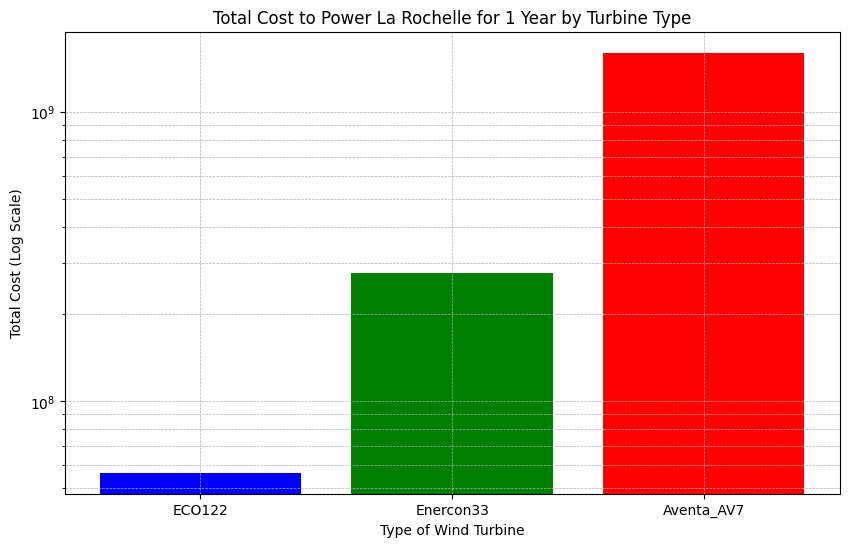

In [46]:
power, operation_time, capacity_factor=turbine_data_per_year(2023)
ECO122_power = power[0]
Enercon33_power=power[1]
Aventa_AV7_power=power[2]
la_rochelle_pop = 78535
la_rochelle_consumption = la_rochelle_pop*2223
ECO122_needed = la_rochelle_consumption/ECO122_power
Enercon33_needed = la_rochelle_consumption/Enercon33_power
Aventa_AV7_needed = la_rochelle_consumption/Aventa_AV7_power
ECO122_operation_time = operation_time[0]
remaining_time = 365-(operation_time[0]/24)
remaining_energy = (remaining_time/365)*la_rochelle_consumption

turbine_costs = {
    'Alstom_ECO122': 3000000,
    'Enercon_E33': 1000000,
    'Aventa_AV7': 150000
}

print(ECO122_needed.round(2), "ECO122 wind turbines needed to power La Rochelle for 1 year")
print(Enercon33_needed.round(2), "Enercon33 wind turbines needed to power La Rochelle for 1 year")
print(Aventa_AV7_needed.round(2), "Aventa_AV7 wind turbines needed to power La Rochelle for 1 year")
print("Since the wind turbines won't generate power for", remaining_time.round(2), "days, the storage capacity must be", remaining_energy.round(2), "kWh")


turbines = ["ECO122", "Enercon33", "Aventa_AV7"]
values = [ECO122_needed, Enercon33_needed, Aventa_AV7_needed]
total_costs = [values[i] * list(turbine_costs.values())[i] for i in range(len(turbines))]

plt.figure(figsize=(10, 6))
plt.bar(turbines, values, color=['blue', 'green', 'red'])
plt.yscale('log')
plt.xlabel('Type of Wind Turbine')
plt.ylabel('Number of Wind Turbines Needed (Log Scale)')
plt.title('Number of Wind Turbines Needed to Power La Rochelle for 1 Year')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig("turbines_needed.webp")
plt.close()

plt.figure(figsize=(10, 6))
plt.bar(turbines, total_costs, color=['blue', 'green', 'red'])
plt.yscale('log')
plt.xlabel('Type of Wind Turbine')
plt.ylabel('Total Cost (Log Scale)')
plt.title('Total Cost to Power La Rochelle for 1 Year by Turbine Type')
plt.grid(True, which="both", ls="--", linewidth=0.5)



I admit that wind turbines are not the most potent source of electric energy, but this is a large amount of wind turbines needed to power a small town. I suppose that of all the wind turbine types, ECO122 would be the most feasible. Sure, greater size might bring greater costs. But 19 large ECO122 turbines still won't be anywhere near the cost of placing almost 11 thousand mini-sized Aventa AV7 turbines.

Also, I am a bit unsure if I did the last calculation for the storage capacity correctly. Keeping track between kWh per day and kWh per year is rather difficult sometimes.

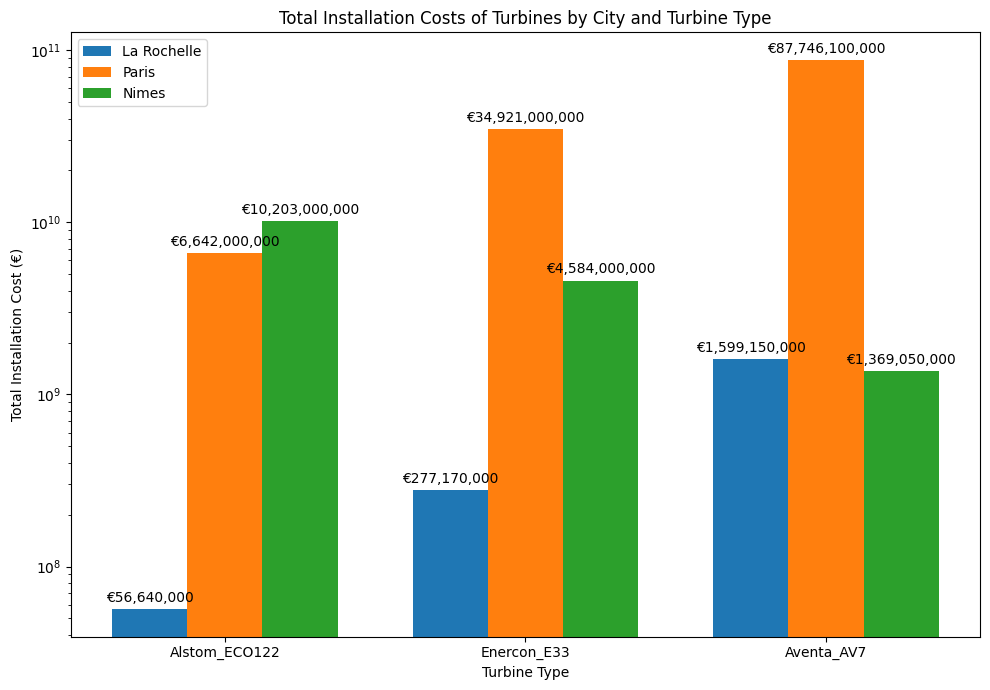

In [5]:
turbines = ["ECO122", "Enercon33", "Aventa_AV7"]
turbine_costs = {
    'Alstom_ECO122': 3000000,
    'Enercon_E33': 1000000,
    'Aventa_AV7': 150000
}

turbines_needed_LaRochelle = {'Alstom_ECO122': 18.88, 'Enercon_E33': 277.17, 'Aventa_AV7': 10661}
turbines_needed_Paris={'Alstom_ECO122': 2214.0, 'Enercon_E33': 34921.0, 'Aventa_AV7': 584974.0}
turbines_needed_Nimes={'Alstom_ECO122': 3401, 'Enercon_E33': 4584, 'Aventa_AV7': 9127}


# Calculate total costs
costs_LaRochelle = {k: turbines_needed_LaRochelle[k] * turbine_costs[k] for k in turbines_needed_LaRochelle}
costs_Paris = {k: turbines_needed_Paris[k] * turbine_costs[k] for k in turbines_needed_Paris}
costs_Nimes = {k: turbines_needed_Nimes[k] * turbine_costs[k] for k in turbines_needed_Nimes}

# Data for plotting
labels = ['Alstom_ECO122', 'Enercon_E33', 'Aventa_AV7']
LaRochelle_costs = [costs_LaRochelle[label] for label in labels]
Paris_costs = [costs_Paris[label] for label in labels]
Nimes_costs = [costs_Nimes[label] for label in labels]

# Create the bar chart
x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

# Plot each city
bars_LaRochelle = ax.bar(x - width, LaRochelle_costs, width, label='La Rochelle')
bars_Paris = ax.bar(x, Paris_costs, width, label='Paris')
bars_Nimes = ax.bar(x + width, Nimes_costs, width, label='Nimes')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Turbine Type')
ax.set_ylabel('Total Installation Cost (€)')
ax.set_title('Total Installation Costs of Turbines by City and Turbine Type')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('€{:,.0f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels on the bars
add_labels(bars_LaRochelle)
add_labels(bars_Paris)
add_labels(bars_Nimes)

fig.tight_layout()

plt.show()
